<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/Binario_CEL_inception_v4_BalanceoSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [2]:
!pip install fastai==2.6.3 -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'restart': True, 'status': 'ok'}

In [2]:
!pip install wwf -q
# !pip install nbdev

In [3]:
from fastai.vision.all import *

import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-19 10:17:29 URL:https://ucd446a89693ea257241ed0b912b.dl.dropboxusercontent.com/cd/0/inline2/BndFbY6oVB9UXJs1pCOPRQawVAibwMAVRYpzd3RtdnVBu0onN_I4ATofIpFnN_Hmi7Tl47Xbz_hPF_tb717zEu_UfKn7bzogqL2OCCnFitSpHWlvNfZo3dVVw0MVguhFh9UHWNteAW5ZNLeHCDE23pfwZwuf__hIFXA1hIouGt3Fe_bMCoiwa7_JG4hyPWlmCu4UJ1sUr_k1Qp7-4ZL1zlWJLA0zXtkWwMsY5rsUr714oCHBCwGFqQnz-Cj-4qIKn3MqMj2LK2nQSIsoyBZUo9_i-oSg9uTh9pS56kpxu_9IK6j_eKm7xlWWK18QCTWyBkN7liswk7Vydsn3C5lfnx2rzDgae2vm-MqIJ8zKy2lekuRuZsJWGXsV0h42G0Rwv8jX3FZpcVzB-zwBi_FEN8bY54A_AvxHWQ_mI5CxmK3cgA/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 10:17:34 URL:https://ucfdc54667abe678f64d0e8ed870.dl.dropboxusercontent.com/cd/0/inline2/Bnc2SQMqETFoU8o3JR8lYVExA2kfRykLx_H3Ltgek-Nd58ibYPMB1DgVspYpSlwCti4CR_pI5eRywIp9d_JF4lPjVV3rSlmT9wJ-c8_cw3eIlXoG7_3dBqU6bDG8BsoM7LkBNW-KibLqELN2YcqJXADkrlFFTCnIA78wyadXJoH1fws6IfcD5WsgP0RfXgTTfOhYIwucgDfXQUVpn41tg19uRU2nkydlR8RGaYj9qaXxZcLws7txpP_BaBQlxXwVWJfgDQWYLfKIblXEt-o7F-PhH7QYMvP9wa_WWGhKroQ99zVHYvKTczcJBHv0TD_PfB9

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [10]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [11]:
path = Path('dataset')

## Balanceo

In [12]:
from sklearn.utils import resample

In [13]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

In [14]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [15]:
len(df_minority_upsampled.ID.unique())

359

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [16]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [17]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [18]:
dls = db.dataloaders(path,bs=128)

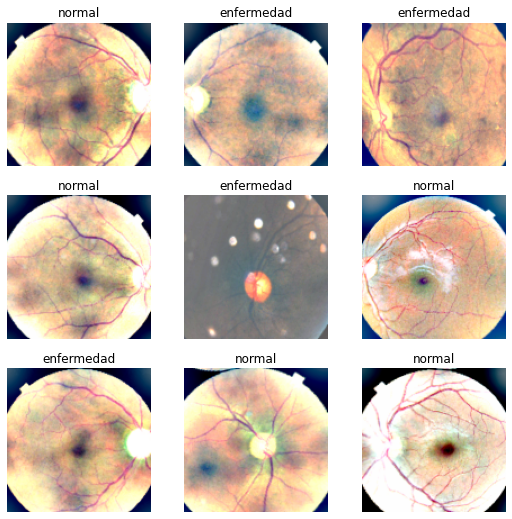

In [19]:
dls.show_batch()

In [20]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [57]:
metrics = [ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = timm_learner(dls, 'inception_v4', metrics=metrics, cbs=callbacks).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


SuggestedLRs(minimum=0.006918309628963471, steep=6.309573450380412e-07, valley=0.0010000000474974513, slide=0.004365158267319202)

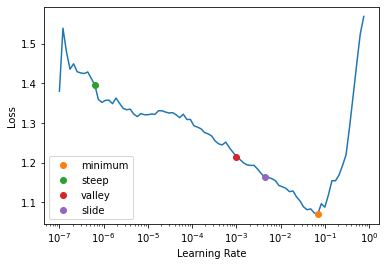

In [58]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.306707,0.758081,0.550000,0.232639,0.500000,0.317536,0.450000,00:10


Better model found at epoch 0 with valid_loss value: 0.7580810785293579.


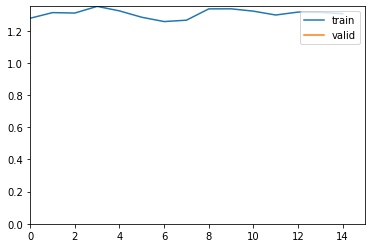

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.158710,0.749254,0.595312,0.254902,0.485075,0.334190,0.404687,00:12
1,1.151785,0.731559,0.607813,0.272374,0.522388,0.358056,0.392188,00:11
2,1.131659,0.780043,0.571875,0.260274,0.567164,0.356808,0.428125,00:12
3,1.121177,0.765758,0.587500,0.274306,0.589552,0.374408,0.412500,00:11
4,1.113058,0.679816,0.660937,0.327801,0.589552,0.421333,0.339063,00:11
5,1.093589,0.662167,0.660937,0.324895,0.574627,0.415094,0.339063,00:11
6,1.067463,0.696289,0.634375,0.322695,0.679104,0.437500,0.365625,00:11
7,1.045167,0.643144,0.675000,0.348361,0.634328,0.449735,0.325000,00:11
8,1.021287,0.603755,0.707812,0.376744,0.604478,0.464183,0.292188,00:11
9,0.998257,0.635724,0.664062,0.344828,0.671642,0.455696,0.335938,00:11


Better model found at epoch 0 with valid_loss value: 0.749253511428833.


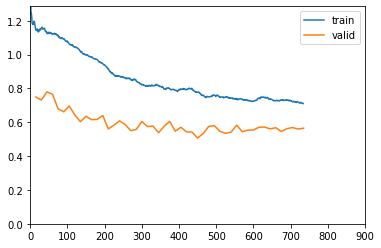

Better model found at epoch 1 with valid_loss value: 0.7315589189529419.
Better model found at epoch 4 with valid_loss value: 0.6798160672187805.
Better model found at epoch 5 with valid_loss value: 0.6621667146682739.
Better model found at epoch 7 with valid_loss value: 0.643144428730011.
Better model found at epoch 8 with valid_loss value: 0.6037546396255493.
Better model found at epoch 13 with valid_loss value: 0.560982346534729.
Better model found at epoch 17 with valid_loss value: 0.5505459904670715.
Better model found at epoch 22 with valid_loss value: 0.5386208295822144.
Better model found at epoch 29 with valid_loss value: 0.5068413615226746.
No improvement since epoch 29: early stopping


In [59]:
learn.fine_tune(60,base_lr=1e-4)

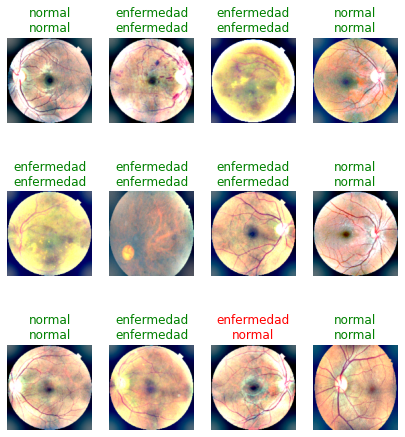

In [60]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [61]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [62]:
learn.dls = dlsTest

In [63]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.770312488079071.


(#6) [1.0050219297409058,0.770312488079071,0.40298507462686567,0.20149253731343283,0.26865671641791045,0.22968749701976776]

Exportamos el modelo:

In [64]:
learn.to_fp32()
learn.export('Binario_CEL_inception_v4_BalanceoSklearn.pkl')

## Interpretación del modelo


In [65]:
learn.dls=dls

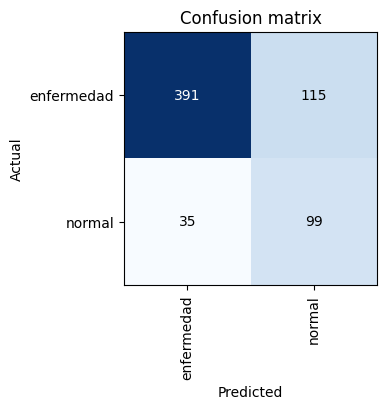

In [66]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)